# Sentiment Analysis with Keras

The purpose here is to predict the sentiment of a tweet/review. This is a classification task, for which Keras will be utilised and different types of neural networks built, trained and tested on the data.

**Data:**

The dataset used for this is the 'Combined Dataset of Tweets,Movie/Book Reviews' found on Kaggle by following the link: https://www.kaggle.com/arshjat/question2/#train.csv

The data contains 2 columns: tweet and sentiment. Sentiment is either 1 for positive or 0 for negative.

In the following, the data is preprocessed and tokenised. Then ConceptNet's Numberbatch word embeddings will be used to create the feature matrix.

**Models:**  
After the data has been prepared, the following models will be used:
+ Simple Neural Network
+ Convolutional Neural Network
+ LSTM Recurrent Neural Network
+ Deep Recurrent Neural Network (with Bidirectional LSTM and GRUs, convolutional layers, batch normalisation and dropout layers)

In [21]:
import pandas as pd
import numpy as np
import re
import os
import gc
import csv
import nltk
from nltk.corpus import stopwords

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D, GRU, CuDNNGRU, CuDNNLSTM, BatchNormalization
from keras.layers import Bidirectional, GlobalMaxPool1D, MaxPooling1D, Add, Flatten
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, SpatialDropout1D
from keras.models import Model, load_model
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras import backend as K
from keras.engine import InputSpec, Layer
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, TensorBoard, Callback, EarlyStopping
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

In [2]:
data = pd.read_csv('data/train.csv',sep=';')
data.shape

(1282902, 2)

In [3]:
data.head()

,tweet,sentiment
0,@FrankieTheSats best interview with mcfly ever...,1
1,@shaundiviney well rnt u smart shaun. u must ...,1
2,i finished my packet of chocolate snakes,0
3,Last night was a fun adventure. The weather i...,1
4,MADDIE I LOVE YOUR OLD FASHIONED WAYS,1


In [4]:
data.isnull().sum()

tweet        0
sentiment    0
dtype: int64

In [5]:
data['tweet'][5]

' http://twitpic.com/3ky85 - Me and James hanging out. .. I love him'

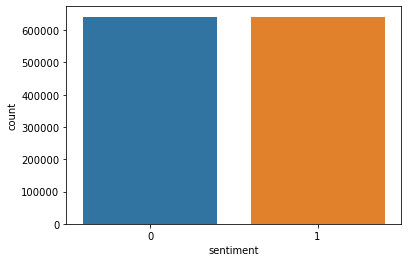

In [6]:
import seaborn as sns

sns.countplot(x='sentiment', data=data)

## Preprocessing and preparing tweets

### Removing unwanted characters

This includes:
+ remove mentions ('@') and website links
+ remove stopwords, punctuation and numbers
+ remove single characters
+ remove mulitple spaces

In [7]:
stop_words = set(stopwords.words('english')) 

data['tweet'] = data['tweet'].apply(lambda x : ' '.join([w.lower() for w in x.split() if not w.startswith(('@','.@','".@','"@','http')) ]))
data['tweet'] = data['tweet'].apply(lambda x : ' '.join([w for w in x.split() if not w in stop_words]))

In [8]:
def preprocess_text(tweet):
    # Remove punctuations and numbers
    tweet = re.sub('[^a-zA-Z]', ' ', tweet)

    # Single character removal
    tweet = re.sub(r"\s+[a-zA-Z]\s+", ' ', tweet)

    # Removing multiple spaces
    tweet = re.sub(r'\s+', ' ', tweet)

    return tweet

In [9]:
processed_tweets = []
tweets = list(data['tweet'])

for tweet in tweets:
    processed_tweets.append(preprocess_text(tweet))

In [10]:
#sanity check all entries retained
len(processed_tweets), len(tweets), data.shape

(1282902, 1282902, (1282902, 2))

In [11]:
#view samples of processed tweets
for i in range(5):
    print(processed_tweets[i])

best interview mcfly ever dougie adorable
well rnt smart shaun must lots fun tho
finished packet chocolate snakes
last night fun adventure weather amazing today m mentally preppin work out legs sore dancing
maddie love old fashioned ways


In [12]:
data['processed_tweets'] = processed_tweets

#check no empty strings as result of processing
data[data.astype(str)['processed_tweets'] =='[]'].sum()

tweet               0.0
sentiment           0.0
processed_tweets    0.0
dtype: float64

In [13]:
data.isnull().sum()

tweet               0
sentiment           0
processed_tweets    0
dtype: int64

In [14]:
#create dependent variable y
y = data['sentiment']

### Train-test split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(processed_tweets, y, test_size=0.20, random_state=42)

### Preparing the Embedding Layer

This will include:
+ Using the Tokeniser class form keras.preprocessing.text to create a word-to-index dictionary, whiere each word in the corpus is a key and a corresponding index is the value for the key. For purposes here, it is fit on the entire dataset to avoid missing words only present in the test set (in real world situations, it would probably only be fit on the train set as the test cases may not yet be available). texts_to_sequences is then called on he train and test tweets to convert the text to sequences
+ Set max_len as 50, which is the maximum length of each list; any greater than this will be truncated, any less than this 0 will be added at the end of the list until it reaches max_len length (padded)
+ Numberbatch embeddings will be used to create the feature matrix; this is loaded and a dictionary is created that will contain words as keys and their corresponding list values
+ An embedding matrix is created where each row number corresponds to the index of the word in the corpus. The number of columns will equal the number of dimensions (to create the n-dimensional embeddings for each word - I think this should be the same as max_len so dot product possible), where each column will contain numberbatch word embeddings for the words in the corpus

In [16]:
tokenizer = Tokenizer(lower = True, filters='')
tokenizer.fit_on_texts(processed_tweets)

train_tokenised = tokenizer.texts_to_sequences(X_train)
test_tokenised = tokenizer.texts_to_sequences(X_test)

In [17]:
#making this nb_words would mean all tokenised words as included in the matrix
vocab_size = len(tokenizer.word_index) + 1

In [18]:
max_len = 50

#lists padded so reach max_len
X_train = pad_sequences(train_tokenised, maxlen = max_len)
X_test = pad_sequences(test_tokenised, maxlen = max_len)

In [19]:
embedding_path = "numberbatch/numberbatch-en-19.08.txt"
embed_size = 300

def get_coefs(word,*arr): 
    return word, np.asarray(arr, dtype='float32')

embedding_index = dict(get_coefs(*o.strip().split(" ")) for o in open(embedding_path))

In [20]:
word_index = tokenizer.word_index
#nb_words = min(vo, len(word_index))
embedding_matrix = np.zeros((vocab_size, embed_size))

for word, i in word_index.items():
    #if want to limit number of features in matrix (rows)
    #if i >= max_features: 
     #   continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None: 
        embedding_matrix[i] = embedding_vector

## Building the models

### Text Classification with a Simple Neural Network

This will be a sequential model with an embedding layer with an input length of 50, and output length of 





. Vocabulary size is vocab_size. As numberbatch embeddings are being used (not own), trainable is set to False, and in weights attriubte the embedding matrix is passes in.

The embedding layer is then added to the model, and as this is directly connected to the densely connected layer, the embedding layer is flattened.

Finally, a dense layer is added with sigmoid activation function.

To compile, adam optimiser is used, with binary_crossentropy as the loss function and accuracy as the metric.

In [31]:
model = Sequential()
embedding_layer = Embedding(vocab_size, embed_size, weights=[embedding_matrix], input_length = max_len , trainable=False)
model.add(embedding_layer)

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

In [32]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model.summary())

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 300)           70894500  
_________________________________________________________________
flatten_1 (Flatten)          (None, 15000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 15001     
Total params: 70,909,501
Trainable params: 15,001
Non-trainable params: 70,894,500
_________________________________________________________________
None


In [33]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)


Train on 821056 samples, validate on 205265 samples
Epoch 1/6
821056/821056 [==============================] - 51s 62us/step - loss: 0.5620 - acc: 0.7165 - val_loss: 0.5427 - val_acc: 0.7263
Epoch 2/6
821056/821056 [==============================] - 49s 59us/step - loss: 0.5376 - acc: 0.7296 - val_loss: 0.5397 - val_acc: 0.7291
Epoch 3/6
821056/821056 [==============================] - 49s 59us/step - loss: 0.5344 - acc: 0.7318 - val_loss: 0.5394 - val_acc: 0.7296
Epoch 4/6
821056/821056 [==============================] - 49s 59us/step - loss: 0.5330 - acc: 0.7327 - val_loss: 0.5397 - val_acc: 0.7295
Epoch 5/6
821056/821056 [==============================] - 49s 60us/step - loss: 0.5321 - acc: 0.7334 - val_loss: 0.5402 - val_acc: 0.7294
Epoch 6/6
821056/821056 [==============================] - 49s 60us/step - loss: 0.5314 - acc: 0.7338 - val_loss: 0.5405 - val_acc: 0.7291


In [34]:
score = model.evaluate(X_test, y_test, verbose=1)

256581/256581 [==============================] - 16s 64us/step


In [35]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.539820950536638
Test Accuracy: 0.7281131744384766


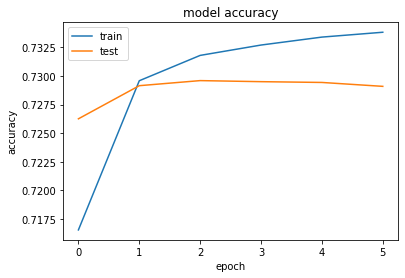

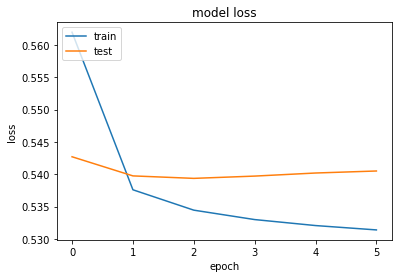

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

### Text Classification with a Convolutional Neural Network (CNN)

A CNN is mainly used for 2D classification; it tries to find specific features in an image in the first layer, and in subsequent layers the initially detected features are joined to form bigger features, and in this way the whole image is detected. CNN's work well with text data, despite being 1D - CNN can extract features from text data.

The following simple CNN will have one convolutional layer and one pooling layer, with the embedding layer staying the same. The 1D convolutional layer will have 128 features/kernels, with the kernel size being 5 and activation function being sigmoid. The global max pooling layer reduces feature size. Finally, a dense layer is added with signoid activation.

In [39]:
nn_model = Sequential()

embedding_layer = Embedding(vocab_size, embed_size, weights=[embedding_matrix], input_length=max_len, trainable=False)
nn_model.add(embedding_layer)

nn_model.add(Conv1D(128, 5, activation='relu'))
nn_model.add(GlobalMaxPooling1D())
nn_model.add(Dense(1, activation='sigmoid'))
nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [40]:
print(nn_model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 300)           70894500  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 46, 128)           192128    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 71,086,757
Trainable params: 192,257
Non-trainable params: 70,894,500
_________________________________________________________________
None


In [41]:
history = nn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

score = nn_model.evaluate(X_test, y_test, verbose=1)

Train on 821056 samples, validate on 205265 samples
Epoch 1/6
821056/821056 [==============================] - 287s 349us/step - loss: 0.5117 - acc: 0.7454 - val_loss: 0.5021 - val_acc: 0.7521
Epoch 2/6
821056/821056 [==============================] - 289s 352us/step - loss: 0.4838 - acc: 0.7646 - val_loss: 0.4962 - val_acc: 0.7559
Epoch 3/6
821056/821056 [==============================] - 292s 356us/step - loss: 0.4655 - acc: 0.7762 - val_loss: 0.4970 - val_acc: 0.7566
Epoch 4/6
821056/821056 [==============================] - 292s 356us/step - loss: 0.4491 - acc: 0.7862 - val_loss: 0.5052 - val_acc: 0.7533
Epoch 5/6
821056/821056 [==============================] - 294s 359us/step - loss: 0.4348 - acc: 0.7949 - val_loss: 0.5173 - val_acc: 0.7481
Epoch 6/6
256581/256581 [==============================] - 53s 208us/step


In [42]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.5234291346923818
Test Accuracy: 0.7487226128578186


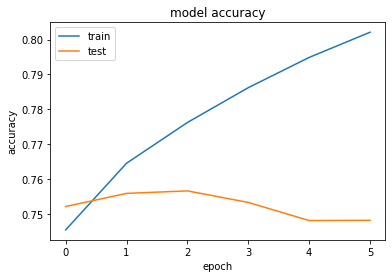

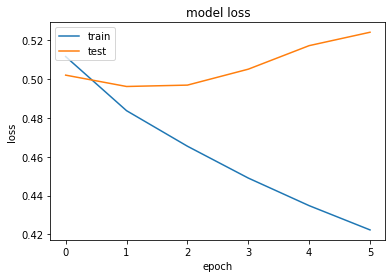

In [43]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

### Text Classification with LSTM Recurrent Neural Network 

These types of networks work well with sequence data, such as sequences of words. After the embedding layer, a LSTM layer is added with 128 neurons - which can be changed - with the rest being as above.

In [45]:
lstm_model = Sequential()
embedding_layer = Embedding(vocab_size, embed_size, weights=[embedding_matrix], input_length=max_len , trainable=False)
lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128))

lstm_model.add(Dense(1, activation='sigmoid'))
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [46]:
print(lstm_model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 300)           70894500  
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               219648    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 71,114,277
Trainable params: 219,777
Non-trainable params: 70,894,500
_________________________________________________________________
None


In [47]:
history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

score = lstm_model.evaluate(X_test, y_test, verbose=1)

Train on 821056 samples, validate on 205265 samples
Epoch 1/6
821056/821056 [==============================] - 923s 1ms/step - loss: 0.5194 - acc: 0.7392 - val_loss: 0.5031 - val_acc: 0.7509
Epoch 2/6
821056/821056 [==============================] - 980s 1ms/step - loss: 0.4943 - acc: 0.7566 - val_loss: 0.4900 - val_acc: 0.7601
Epoch 3/6
821056/821056 [==============================] - 971s 1ms/step - loss: 0.4823 - acc: 0.7643 - val_loss: 0.4841 - val_acc: 0.7643
Epoch 4/6
821056/821056 [==============================] - 967s 1ms/step - loss: 0.4734 - acc: 0.7700 - val_loss: 0.4803 - val_acc: 0.7674
Epoch 5/6
821056/821056 [==============================] - 977s 1ms/step - loss: 0.4652 - acc: 0.7750 - val_loss: 0.4809 - val_acc: 0.7657
Epoch 6/6
256581/256581 [==============================] - 228s 888us/step


In [48]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.4783374218254074
Test Accuracy: 0.7680615186691284


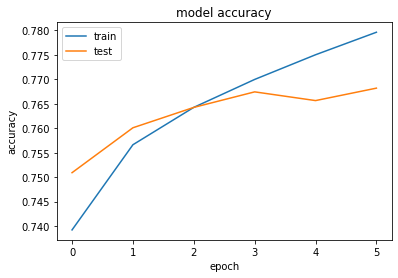

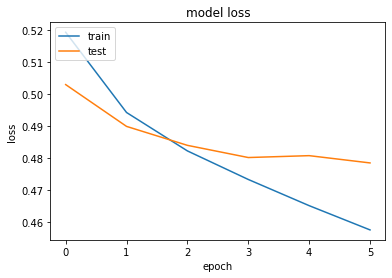

In [49]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

### Text Classification with Deep-RNN Model

This will contain an embedding layer, bidirectional LSTM and GRUs, convolutional layers, followed by batch normalisation and dropout layers.

In [22]:
def build_deep_model(lr=0.0, lr_d=0.0, units=0, spatial_dr=0.0, kernel_size1=3, kernel_size2=2, dense_units=128, dr=0.1, conv_size=32):
    file_path = "best_model.hdf5"
    check_point = ModelCheckpoint(file_path, monitor = "val_loss", verbose = 1,
                                          save_best_only = True, mode = "min")
    early_stop = EarlyStopping(monitor = "val_loss", mode = "min", patience = 3)

    inp = Input(shape = (max_len,))
    x = Embedding(vocab_size, embed_size, weights = [embedding_matrix], trainable = False)(inp)
    x1 = SpatialDropout1D(spatial_dr)(x)

    x_gru = Bidirectional(GRU(units, return_sequences = True))(x1)
    x1 = Conv1D(conv_size, kernel_size=kernel_size1, padding='valid', kernel_initializer='he_uniform')(x_gru)
    avg_pool1_gru = GlobalAveragePooling1D()(x1)
    max_pool1_gru = GlobalMaxPooling1D()(x1)

    x3 = Conv1D(conv_size, kernel_size=kernel_size2, padding='valid', kernel_initializer='he_uniform')(x_gru)
    avg_pool3_gru = GlobalAveragePooling1D()(x3)
    max_pool3_gru = GlobalMaxPooling1D()(x3)

    x_lstm = Bidirectional(LSTM(units, return_sequences = True))(x1)
    x1 = Conv1D(conv_size, kernel_size=kernel_size1, padding='valid', kernel_initializer='he_uniform')(x_lstm)
    avg_pool1_lstm = GlobalAveragePooling1D()(x1)
    max_pool1_lstm = GlobalMaxPooling1D()(x1)

    x3 = Conv1D(conv_size, kernel_size=kernel_size2, padding='valid', kernel_initializer='he_uniform')(x_lstm)
    avg_pool3_lstm = GlobalAveragePooling1D()(x3)
    max_pool3_lstm = GlobalMaxPooling1D()(x3)

    x = concatenate([avg_pool1_gru, max_pool1_gru, avg_pool3_gru, max_pool3_gru,
                            avg_pool1_lstm, max_pool1_lstm, avg_pool3_lstm, max_pool3_lstm])
    x = BatchNormalization()(x)
    x = Dropout(dr)(Dense(dense_units, activation='relu') (x))
    x = BatchNormalization()(x)
    x = Dropout(dr)(Dense(int(dense_units / 2), activation='relu') (x))
    x = Dense(1, activation = "sigmoid")(x)
    model = Model(inputs = inp, outputs = x)

    model.compile(loss = "binary_crossentropy", optimizer = Adam(lr = lr, decay = lr_d), metrics = ["accuracy"])

    history = model.fit(X_train, y_train, batch_size = 128, epochs = 10, validation_split=0.1, 
                                verbose = 1, callbacks = [check_point, early_stop])

    model = load_model(file_path)

    return model

In [23]:
deep_model = build_deep_model(lr = 1e-3, lr_d = 1e-10, units = 128, spatial_dr = 0.5, kernel_size1=4, kernel_size2=4, dense_units=64, dr=0.2, conv_size=32)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 923688 samples, validate on 102633 samples
Epoch 1/10
923688/923688 [==============================] - 2735s 3ms/step - loss: 0.5535 - accuracy: 0.7150 - val_loss: 0.5345 - val_accuracy: 0.7325

Epoch 00001: val_loss improved from inf to 0.53451, saving model to best_model.hdf5
Epoch 2/10
923688/923688 [==============================] - 2736s 3ms/step - loss: 0.5235 - accuracy: 0.7379 - val_loss: 0.5023 - val_accuracy: 0.7521

Epoch 00002: val_loss improved from 0.53451 to 0.50234, saving model to best_model.hdf5
Epoch 3/10
923688/923688 [==============================] - 2732s 3ms/step - loss: 0.5122 - accuracy: 0.7462 - val_loss: 0.5790 - val_accuracy: 0.7153

Epoch 00003: val_loss did not improve from 0.50234
Epoch 4/10
923688/923688 [==============================] - 2732s 3ms/step - loss: 0.5048 - accuracy: 0.7509 - val_loss: 0.4904 - val_accuracy: 0.7610

Epoch 00004: val_loss 

In [24]:
score = deep_model.evaluate(X_test, y_test, verbose=1)

256581/256581 [==============================] - 437s 2ms/step


In [25]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.4747343453303665
Test Accuracy: 0.7687786817550659


From the above, the model that performed best - i.e. has the highest accuracy - is the deep model at 76.88% accuracy. However, the performance is only marginally better than the LSTM model with accuracy of 76.81%. 

To see if it improve performance, alternative embeddings - such as GloVe - could be used.